In [267]:
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset, TensorDataset, random_split
from tqdm import tqdm
from PIL import Image

import matplotlib.pyplot as plt


*Note*: There are some other libraries that may be used to further enhance quality of the code. Some of these are, 

1. ipympl: Enables interactive matplotlib plots in jupyter

# Create Synthetic dataset

Synthetic dataset 1

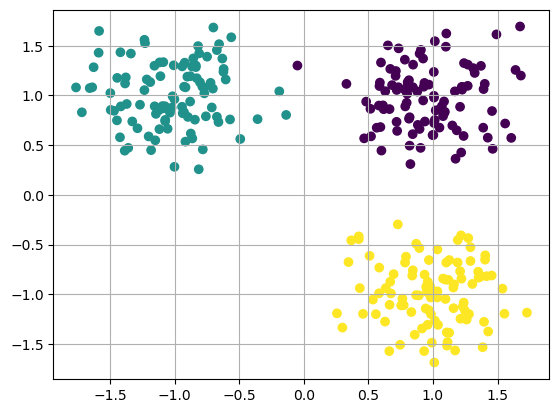

In [268]:
# cluster attributes (means and covariances)
mean1, cov1 = [1,1], [[0.1,0], [0,0.1]]
mean2, cov2 = [-1,1], [[0.1,0], [0,0.1]]
mean3, cov3 = [1, -1], [[0.1, 0], [0, 0.1]]

n = 100 # number of points per cluster

# generate samples
cluster1 = np.random.multivariate_normal(mean1, cov1, n)
cluster2 = np.random.multivariate_normal(mean2, cov2, n)
cluster3 = np.random.multivariate_normal(mean3, cov3, n)

# create dataset by concatenating all the clusters
X = np.vstack([cluster1, cluster2, cluster3]) # input
y = np.array(([0.]*n, [1.]*n, [2.]*n)) # labels
y = y.flatten()

# visualize
fig, ax = plt.subplots()
ax.scatter(X[:,0], X[:,1], c=y)
ax.grid(True)
plt.show()

Synthetic dataset 2

In [269]:
from PIL import Image

# Open the image
img = Image.open("C:/Users/Zayan/Documents/code/personal_repos/adaptive vector quantization/assets/dataset1.png")

# Convert the image to RGBA (if it's not already in that format)
img = img.convert("RGBA")

# Get the size of the image
width, height = img.size

# Prepare a list to hold coordinates and color of colored points
data = []

# Loop through each pixel in the image
for i in range(width):
    for j in range(height):
        # Get the color of the pixel (excluding alpha channel for simplicity)
        r, g, b, a = img.getpixel((i, j))
        if (r, g, b) != (255, 255, 255):  # Assuming white is the background color
            # Store both coordinates and color
            data.append(((i, j), (r, g, b)))

df = pd.DataFrame(data, columns=['coordinate', 'rgb'])
df.head()

,coordinate,rgb
0,"(346, 226)","(237, 238, 250)"
1,"(346, 227)","(147, 153, 227)"
2,"(346, 228)","(81, 89, 209)"
3,"(346, 229)","(63, 72, 204)"
4,"(346, 230)","(63, 72, 204)"


In [270]:
df.rgb.unique()

array([(237, 238, 250), (147, 153, 227), (81, 89, 209), (63, 72, 204),
       (69, 78, 206), (117, 124, 219), (183, 186, 236), (243, 244, 252),
       (219, 221, 245), (171, 175, 232), (123, 130, 220), (195, 198, 239),
       (159, 163, 229), (75, 84, 207), (111, 118, 217), (207, 209, 242),
       (249, 249, 253), (225, 226, 247), (99, 107, 214), (177, 180, 234),
       (165, 169, 231), (63, 71, 204), (63, 72, 203), (189, 192, 237),
       (231, 232, 249), (135, 141, 224), (87, 95, 211), (129, 135, 222),
       (141, 147, 225), (93, 101, 212), (105, 112, 215), (213, 215, 244),
       (189, 192, 238), (163, 167, 230), (201, 203, 240), (153, 158, 228),
       (85, 92, 209), (116, 122, 217), (66, 75, 204), (255, 252, 207),
       (255, 249, 143), (255, 246, 80), (255, 243, 16), (255, 242, 0),
       (255, 242, 8), (255, 248, 112), (255, 255, 247), (255, 251, 183),
       (255, 243, 24), (255, 246, 72), (255, 244, 32), (255, 248, 127),
       (255, 252, 191), (255, 249, 151), (255, 248, 10

# MLP

In [271]:
class AnotherMLP(nn.Module):
    def __init__(self, D_in, H, D_out):
        super(AnotherMLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(D_in, H),
            nn.Tanh(),  # nn.ReLU()
            nn.Linear(H, D_out)
        )        
    def forward(self, x):
        y_pred = self.layers(x)
        return y_pred

D_in, H, D_out = 2, 2, 1    
net = AnotherMLP(D_in, H, D_out)

## Test 1: Check output of a linear layer

Check dtypes

In [272]:
# check data types
fc1 = nn.Linear(2,2)
print("weights are of type ", fc1.weight.dtype)
print("inputs are of type ", X[0,:].dtype)
print("outputs are of type ", y.dtype)

weights are of type  torch.float32
inputs are of type  float64
outputs are of type  float64


In [273]:
# convert to float32
X = torch.from_numpy(X).float()
y = torch.from_numpy(y).float()
print(X.dtype)
print(y.dtype)

torch.float32
torch.float32


In [274]:
print("weights of first layer = ", fc1.weight)
net_act = fc1(X[0,:])
print("output of first layer = ", net_act)

weights of first layer =  Parameter containing:
tensor([[-0.0027,  0.0303],
        [ 0.6884,  0.3904]], requires_grad=True)
output of first layer =  tensor([-0.4151,  0.6081], grad_fn=<ViewBackward0>)


Put output through nonlinearity

## Test 2: Nonlinearity

In [275]:
LRelu = nn.LeakyReLU()
output = LRelu(net_act)
print("output of LReLu(net_act) = ", output)

output of LReLu(net_act) =  tensor([-0.0042,  0.6081], grad_fn=<LeakyReluBackward0>)


## Test 3: Output and loss

In [276]:
def my_mse(output_vector, label_vector):
    return torch.mean((output_vector-label_vector)**2)

In [277]:
labels = torch.tensor([1.0, 0.0])
loss_fn = nn.MSELoss()

print(f"Predicted outputs = {output}\nTrue outputs = {labels}\nLoss = ",loss_fn(output, labels))

print("Manually calculated MSE = ", my_mse(output, labels))

Predicted outputs = tensor([-0.0042,  0.6081], grad_fn=<LeakyReluBackward0>)
True outputs = tensor([1., 0.])
Loss =  tensor(0.6891, grad_fn=<MseLossBackward0>)
Manually calculated MSE =  tensor(0.6891, grad_fn=<MeanBackward0>)


# Create PyTorch Dataset

In [278]:

# create the dataset
dataset = TensorDataset(X, y)

# split the data
train_size = int(0.8*len(dataset))
val_size = len(dataset) - train_size

train_set, val_set = random_split(dataset, [train_size, val_size])

# create dataloaders
shuffle = True
train_loader = DataLoader(train_set, batch_size=10, shuffle=shuffle)
val_loader = DataLoader(val_set, batch_size=10, shuffle=False)

In [279]:
features, labels = next(iter(train_loader))

print("features = ", features)
print("labels = ", labels)

for i, data in enumerate(train_loader):
    features, labels = data
    print(features)

    if i==2:
        break

features =  tensor([[-0.9273,  0.8317],
        [ 0.2569, -1.1920],
        [ 0.6010,  0.4453],
        [ 1.3047, -0.8966],
        [-1.7179,  0.8303],
        [ 0.4585, -1.1973],
        [-0.9266,  1.0878],
        [-0.3577,  0.7614],
        [-0.7700,  1.0210],
        [ 0.6619, -1.5725]])
labels =  tensor([1., 2., 0., 2., 1., 2., 1., 1., 1., 2.])
tensor([[-1.7631,  1.0804],
        [ 1.1695,  1.0411],
        [ 1.0998,  1.4903],
        [ 0.6619, -1.5725],
        [ 1.3845, -1.5331],
        [ 0.5204,  0.5885],
        [ 1.0326, -1.0331],
        [ 1.4569,  0.8430],
        [ 1.2224,  1.0843],
        [-0.6044,  1.1604]])
tensor([[ 1.0390, -1.3083],
        [ 0.6290, -1.2752],
        [ 1.0503,  0.6765],
        [-1.2154,  1.1609],
        [ 0.2569, -1.1920],
        [ 0.4255, -0.4181],
        [ 0.3300,  1.1163],
        [-0.7038,  1.0686],
        [ 0.6690, -0.8747],
        [ 0.4828,  0.9377]])
tensor([[-0.8649,  1.2912],
        [ 1.1625, -0.9007],
        [-0.1367,  0.8039],
  

## Training loop 1

Data in known sequence

In [280]:
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.001)

  0%|          | 0/100 [00:00<?, ?it/s]

0th epoch, total loss =  43.057854652404785
0th epoch, average loss per batch =  1.8720806370610776


c:\Users\Zayan\anaconda3\envs\nn\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  6%|▌         | 6/100 [00:00<00:01, 52.35it/s]

10th epoch, total loss =  24.440405905246735
10th epoch, average loss per batch =  1.0626263437063799


 18%|█▊        | 18/100 [00:00<00:01, 53.66it/s]

20th epoch, total loss =  18.9369255900383
20th epoch, average loss per batch =  0.8233445908712305


 30%|███       | 30/100 [00:00<00:01, 53.03it/s]

30th epoch, total loss =  17.145647674798965
30th epoch, average loss per batch =  0.7454629423825637


 36%|███▌      | 36/100 [00:00<00:01, 54.21it/s]

40th epoch, total loss =  16.539206624031067
40th epoch, average loss per batch =  0.7190959401752638


 48%|████▊     | 48/100 [00:00<00:00, 55.18it/s]

50th epoch, total loss =  16.29932340979576
50th epoch, average loss per batch =  0.7086662352085114


 60%|██████    | 60/100 [00:01<00:00, 55.82it/s]

60th epoch, total loss =  16.099213361740112
60th epoch, average loss per batch =  0.6999657983365266


 72%|███████▏  | 72/100 [00:01<00:00, 56.75it/s]

70th epoch, total loss =  15.931555330753326
70th epoch, average loss per batch =  0.6926763187284055


 78%|███████▊  | 78/100 [00:01<00:00, 57.47it/s]

80th epoch, total loss =  15.951312363147736
80th epoch, average loss per batch =  0.693535320136858


 90%|█████████ | 90/100 [00:01<00:00, 57.56it/s]

90th epoch, total loss =  15.957870155572891
90th epoch, average loss per batch =  0.6938204415466475


100%|██████████| 100/100 [00:01<00:00, 54.91it/s]


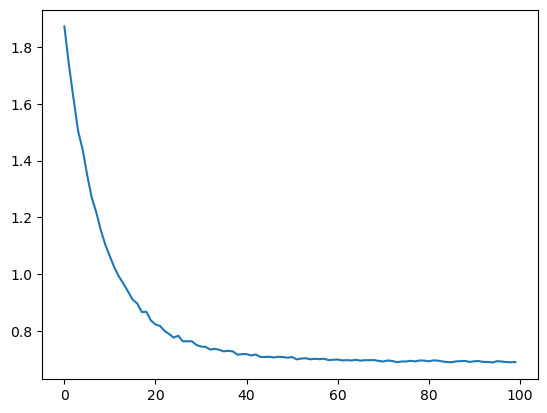

In [281]:
epoch_total_losses = []
epoch_mean_losses = []
for epoch in tqdm(range(100)):
    epoch_loss = 0.0
    for i, data in enumerate(train_loader):
        optimizer.zero_grad()
        inputs, labels = data
        outputs = net(inputs)

        loss = criterion(outputs, labels)
        loss.backward()

        optimizer.step()

        # calculate total loss for this epoch
        epoch_loss += loss.item()

    # store epoch losses
    epoch_total_losses.append(epoch_loss) # total loss in current epoch
    epoch_mean_losses.append(epoch_loss/i) # mean loss per batch this current epoch

    # report every 10th epoch
    if epoch % 10 == 0:
        print(f"{epoch}th epoch, total loss = ", epoch_loss)
        print(f"{epoch}th epoch, average loss per batch = ", epoch_mean_losses[-1])

# visualize
fig, ax = plt.subplots()
ax.plot(epoch_mean_losses)
plt.show()

In [282]:
def loss_per_batch(running_loss, batch_num):
    pass

def train_one_epoch(epoch_index):
    epoch_loss = 0.0
    

    for i, data in enumerate(train_loader):

        optimizer.zero_grad()
        inputs, labels = data
        outputs = net(inputs)

        batch_loss = criterion(outputs, labels)
        batch_loss.backward()

        optimizer.step()

        epoch_loss += batch_loss

        print(f"{i}th batch loss = {batch_loss}")
    
    return epoch_loss


